**FALLBACK PARA O MATPLOTLIB**

In [2]:
# fallback pro matplotlib
# 1) Criar o alias que o matplotlib-inline 0.2.x espera
import matplotlib, sys, importlib
if not hasattr(matplotlib.rcParams, "_get"):
    matplotlib.rcParams._get = matplotlib.rcParams.__getitem__

# 2) Se o backend_inline já tiver sido importado e falhado, recarregue
if "matplotlib_inline.backend_inline" in sys.modules:
    importlib.reload(sys.modules["matplotlib_inline.backend_inline"])

# 3) Agora é seguro importar o pyplot
import matplotlib.pyplot as plt
# fim do fallback

# Modelo SIR — Suscetíveis, Infectados, Recuperados (Removidos) — Kermack e McKendrick

* $S$: Suscetíveis a contrair uma patologia
* $I$: Infectados pela patologia
* $R$: Recuperados da (ou eliminados pela) patologia

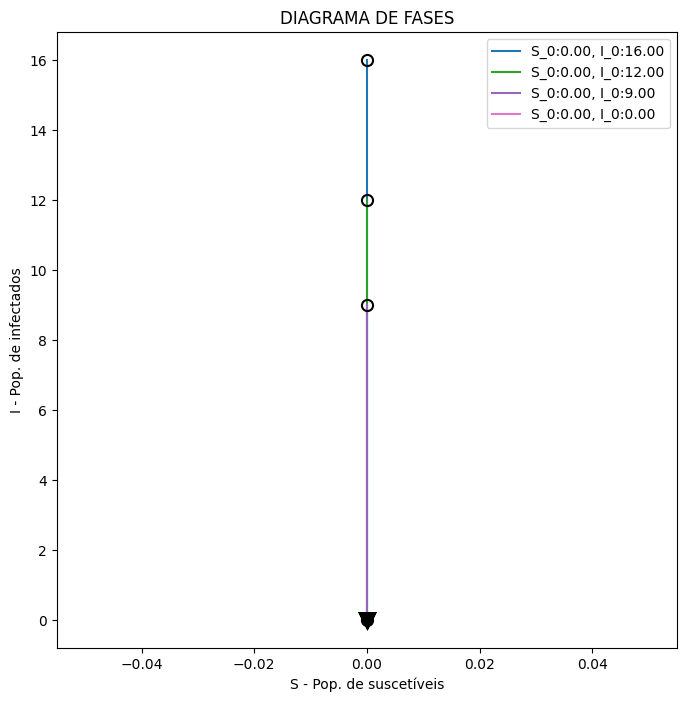

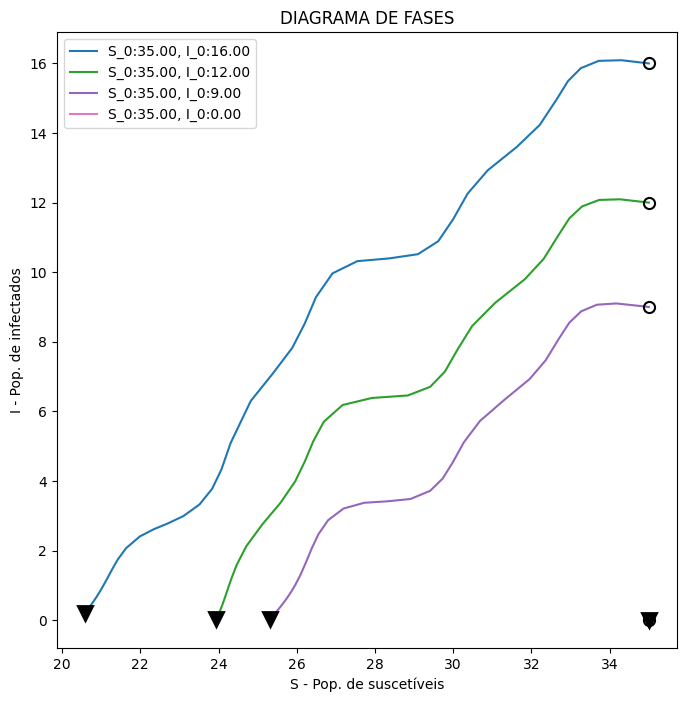

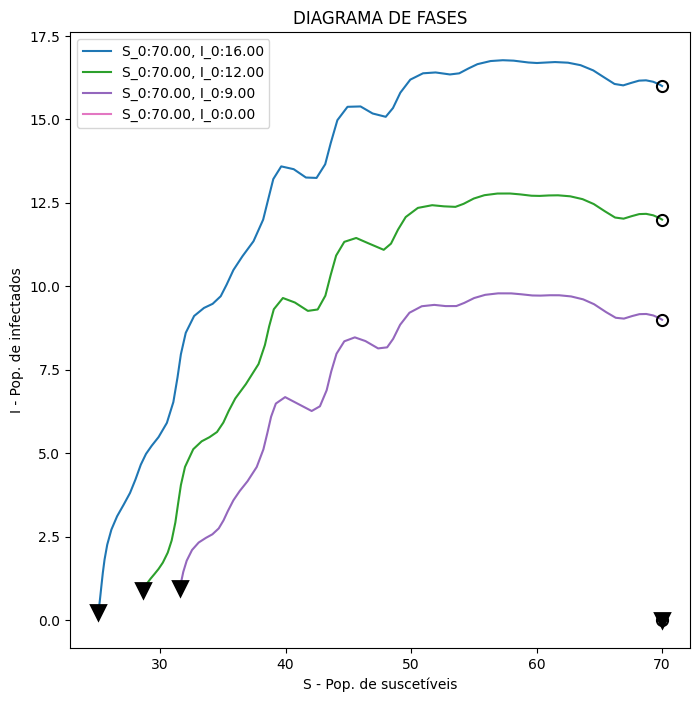

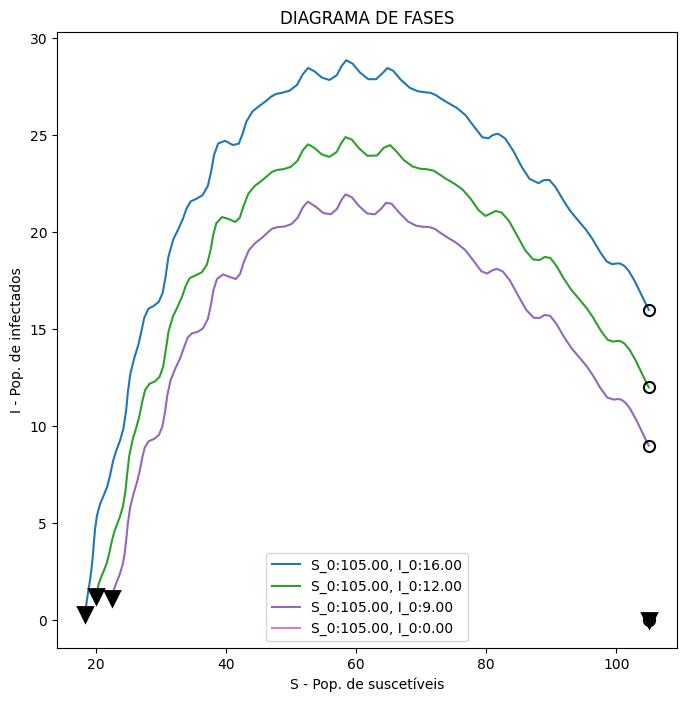

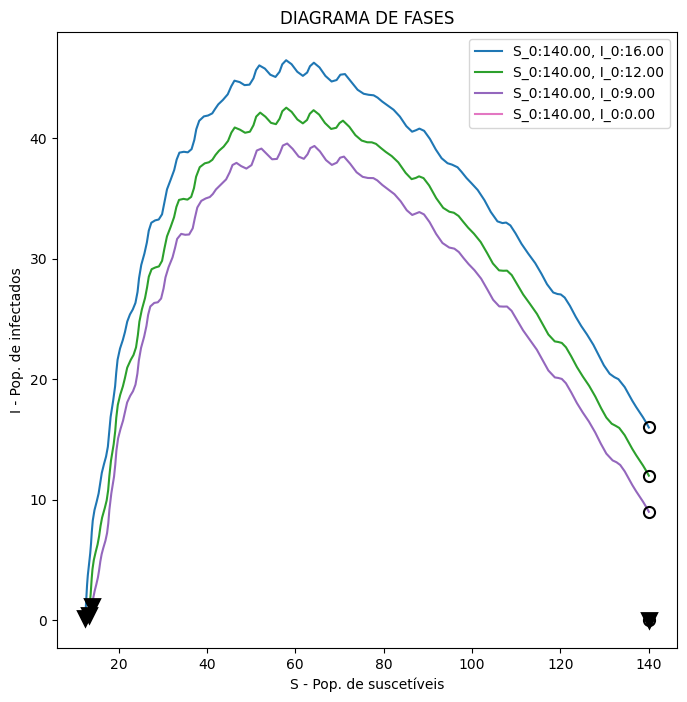

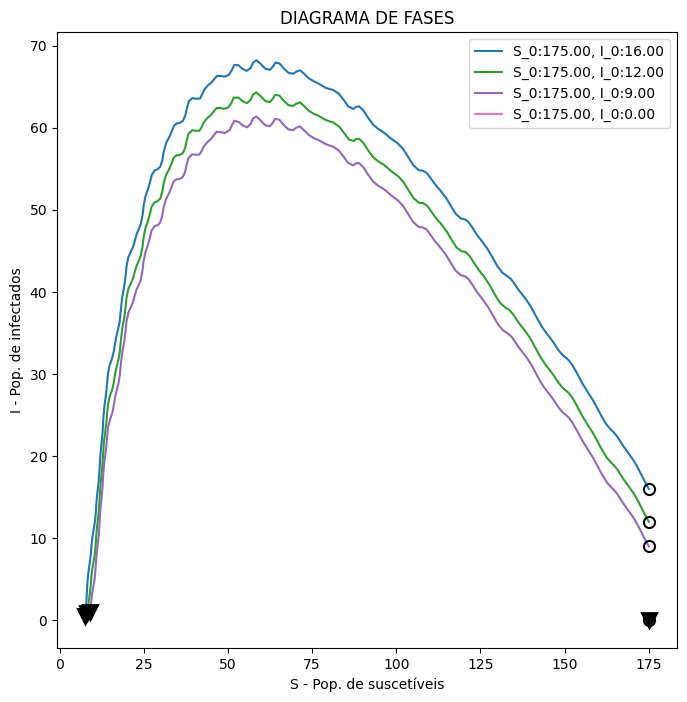

In [93]:
import numpy as np
from scipy.integrate import solve_ivp

as_fun = lambda p: p if callable(p) else lambda t, S, I, R: float(p)


N = 200 # numero total de individuos

'''
    beta: taxa de contato / infecção
    gamma: taxa de recuperacao
    Se quisermos simular um surto, beta > gamma,
    do contrário, gamma < beta
'''
surto = True
beta, gamma = (27/7, 9/8) if surto else (9/8, 9/5)

a0 = beta / N
b0 = gamma

invariante = False

a = lambda t, S, I, R : a0/2 + (a0/4) * np.exp(-0.001*I) + (a0/4) * np.cos(R)
b = lambda t, S, I, R : 3*b0/4 + (b0/4) * np.cos(S)

# para mapear constentes para funções, se for o caso
a, b, = map(
    as_fun, [a, b] if not invariante else [a0, b0]
)

def sistema_edo(t, z):
    S, I, R = z
    return [
        -a(t, S, I, R) * S * I, # dS/dt
        a(t, S, I, R) * S * I - b(t, S, I, R) * I, # dI/dt
        b(t, S, I, R) * I # dR/dt
    ]

def integrate(
    fn : callable,
    t0,
    tf,
    S0,
    I0,
    R0
):
    N0_ivp = [S0, I0, R0]
    sol = solve_ivp(
        fn,
        (t0, tf),
        N0_ivp,
        method = 'RK45',
        rtol = 1e-6,
        atol = 1e-9,
        dense_output = True
    )
    return sol.t, *sol.y

samples = 6
S_0_array = np.clip(
    (b0/a0) * np.linspace(0, 3, samples), 0, N
)
I_0_array = np.array(
    [N/12.5, N/16.667, N/22.222, 0]
)
R_0_array = np.zeros(
    1
)
R_0 = 0
t_final = 8 if invariante else 10

results = {
}

for S_0 in S_0_array:
    for I_0 in I_0_array:
        t, S, I, R = integrate(sistema_edo, 0, t_final, S_0, I_0, R_0)
        results[(S_0, I_0)] = (
            t,
            S,
            I,
            R
        )


for S_0 in S_0_array:
    plt.figure(figsize = (8, 8))
    plt.title('DIAGRAMA DE FASES')
    plt.xlabel('S - Pop. de suscetíveis')
    plt.ylabel('I - Pop. de infectados')
    for I_0 in I_0_array:
        t, S, I, R = results[(S_0, I_0)]
        plt.plot(S, I, label = f'S_0:{S_0:.2f}, I_0:{I_0:.2f}')
        # inicio da trajetoria
        plt.plot(S[0], I[0], marker='o', ms=8, mfc='none', mec='k', mew=1.5, zorder=5)
        # fim da trajetoria
        plt.plot(S[-1], I[-1], marker='v', ms=10, mew=2, color='k', zorder=6)
    plt.legend()
    plt.show()

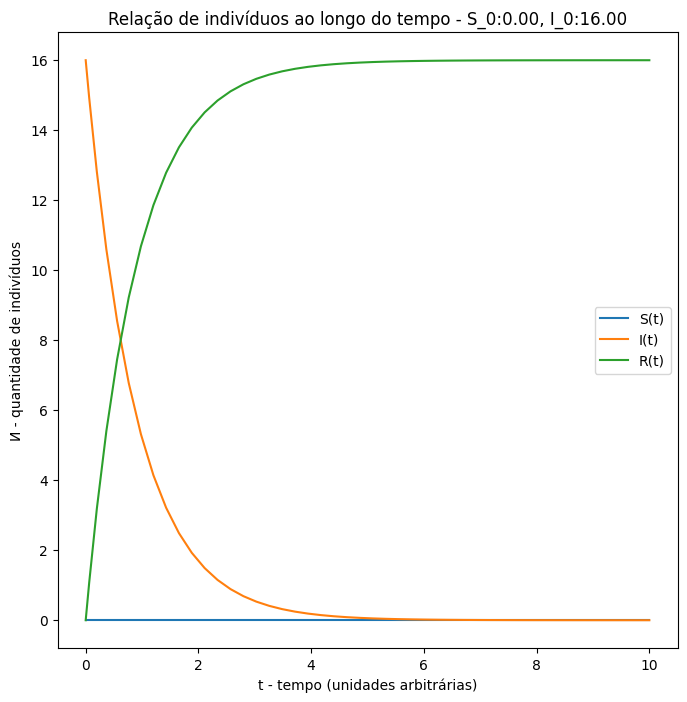

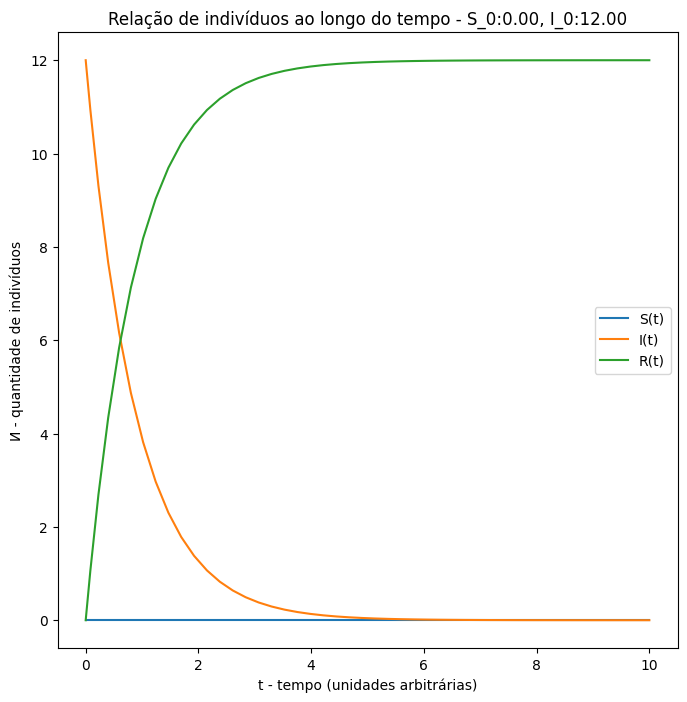

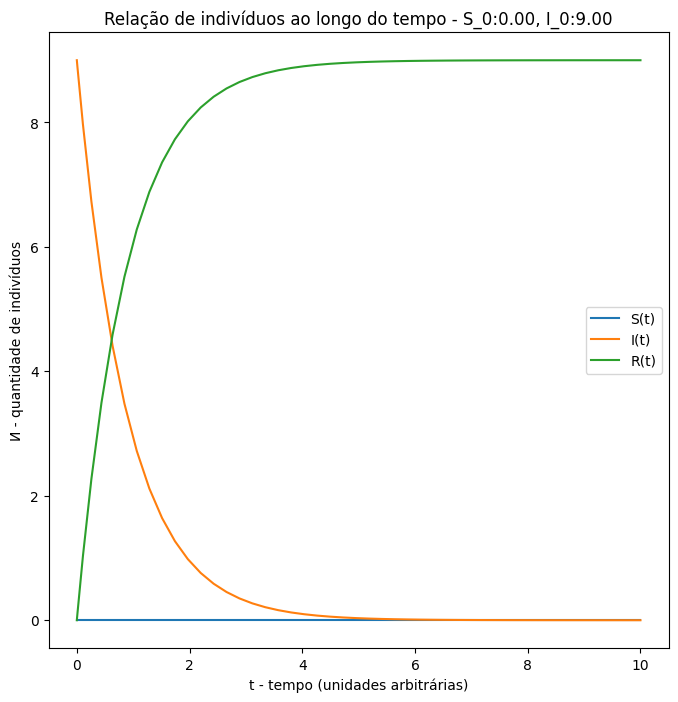

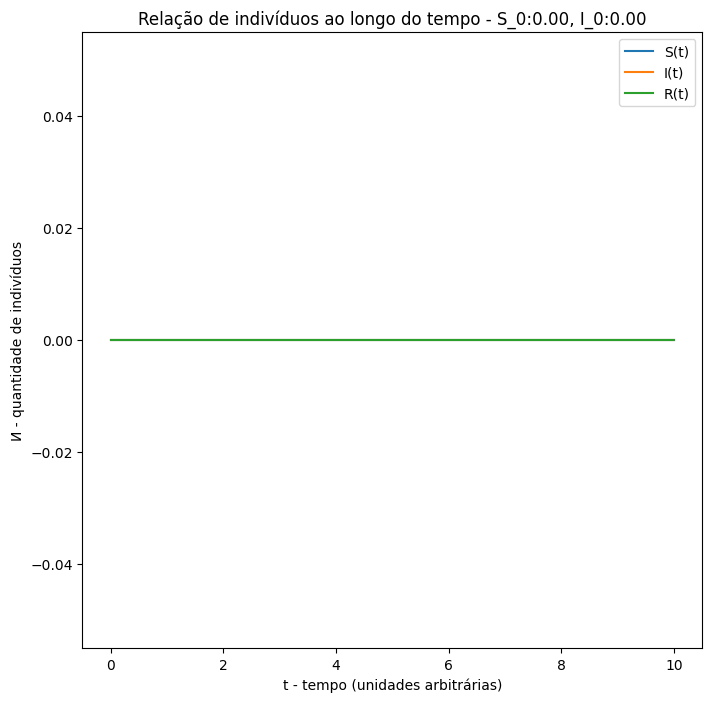

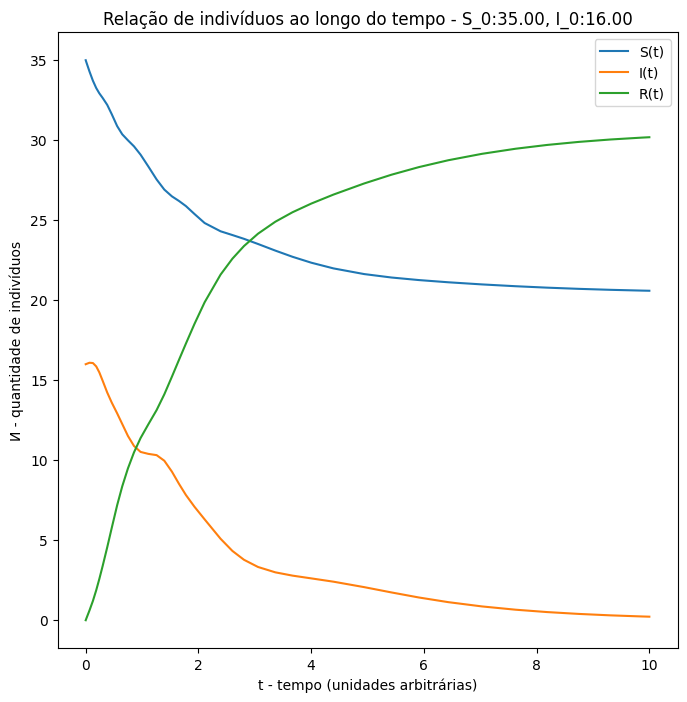

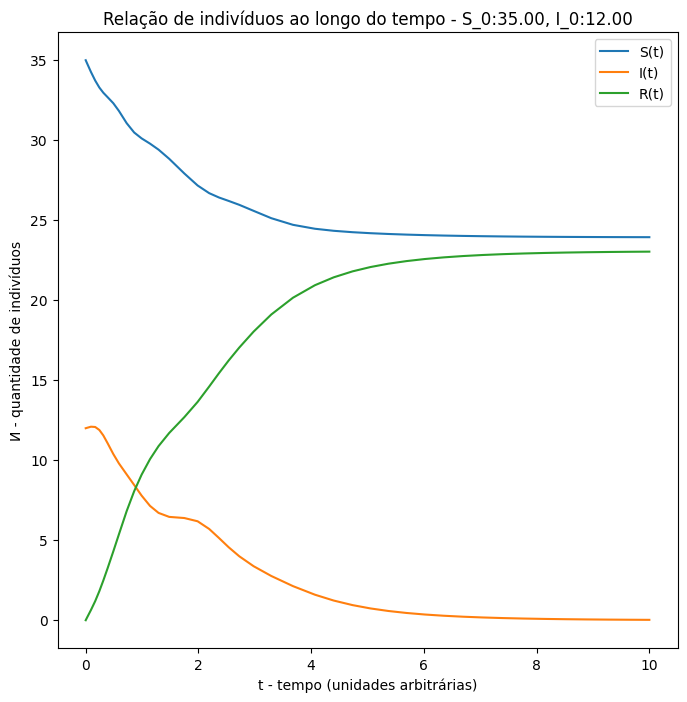

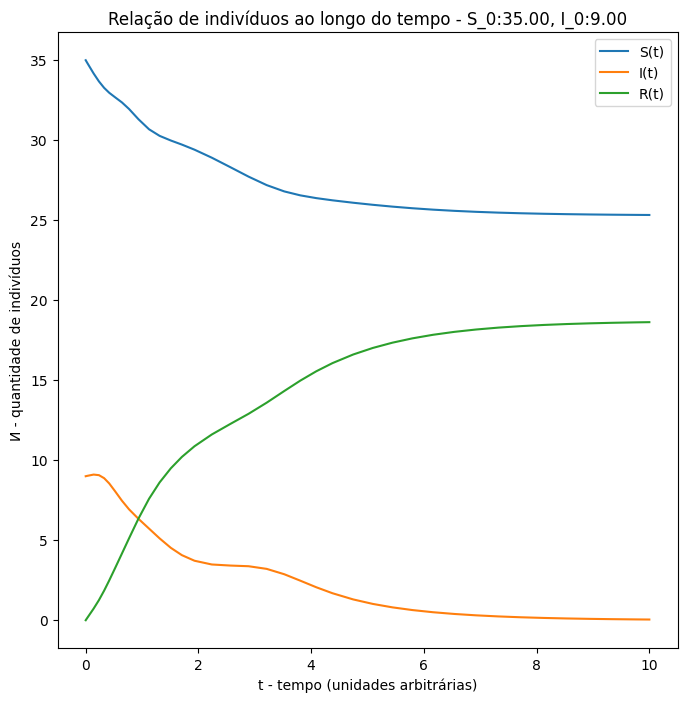

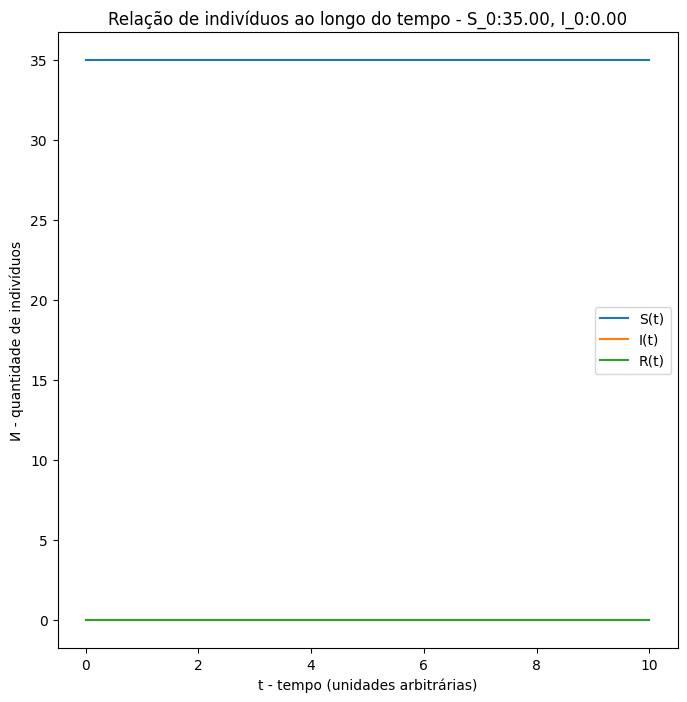

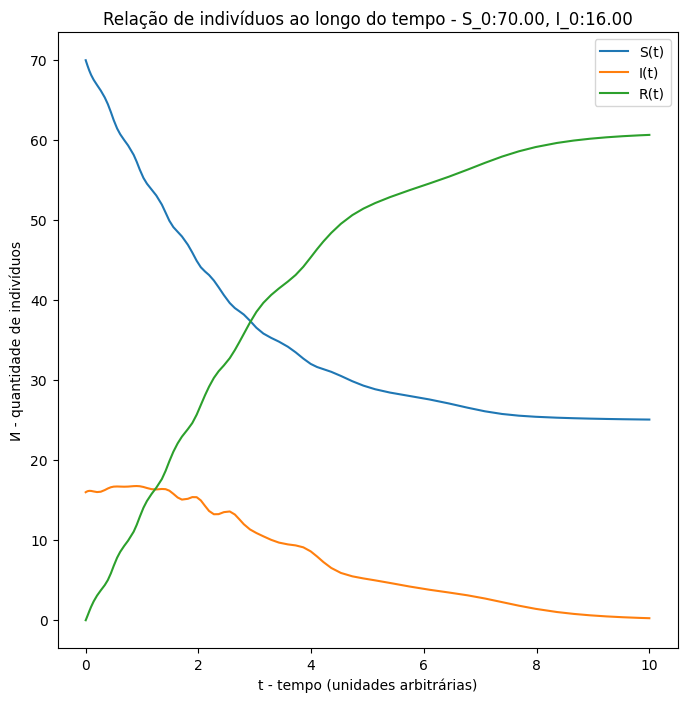

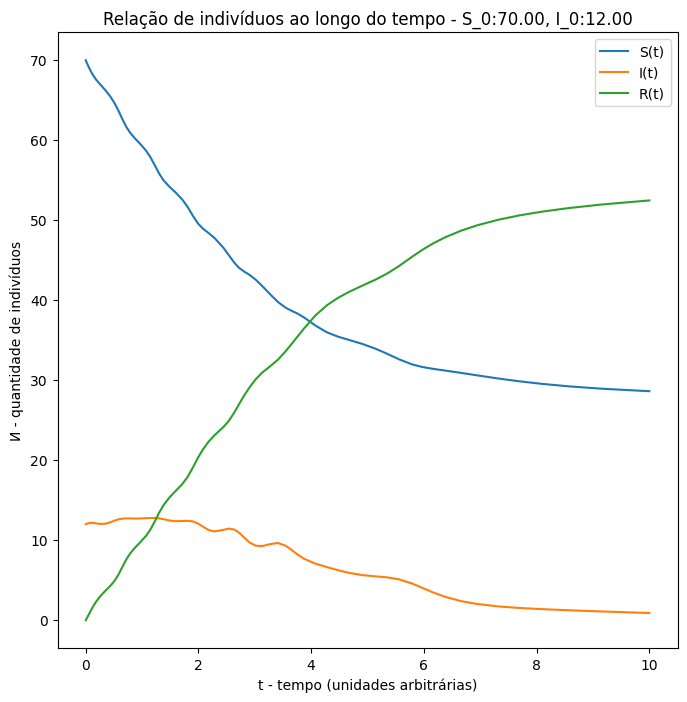

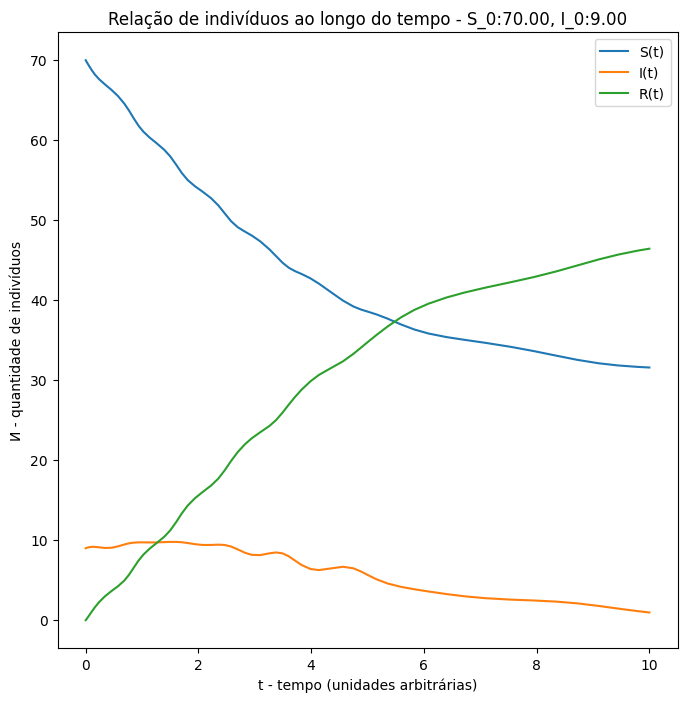

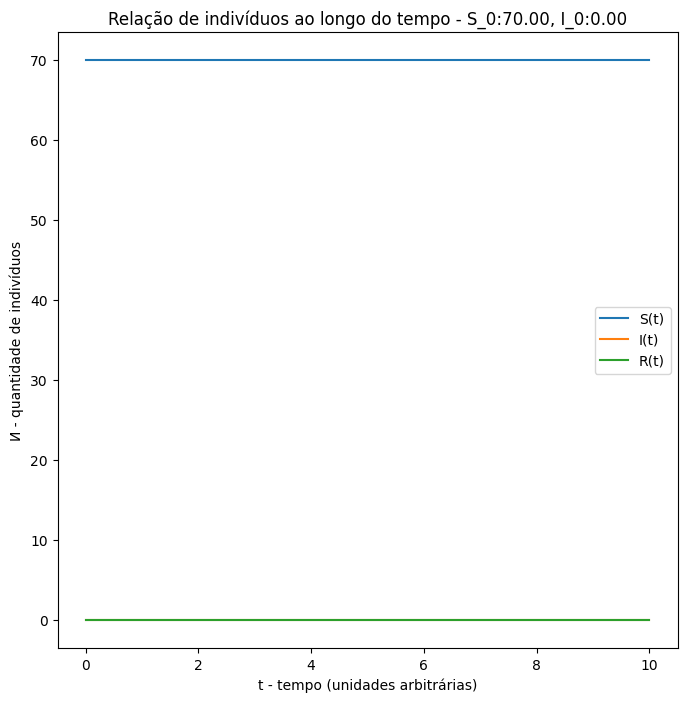

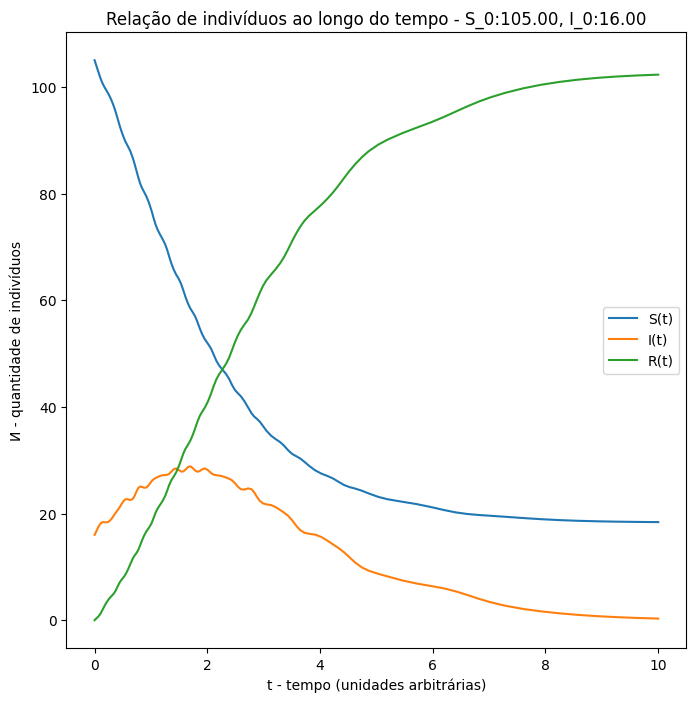

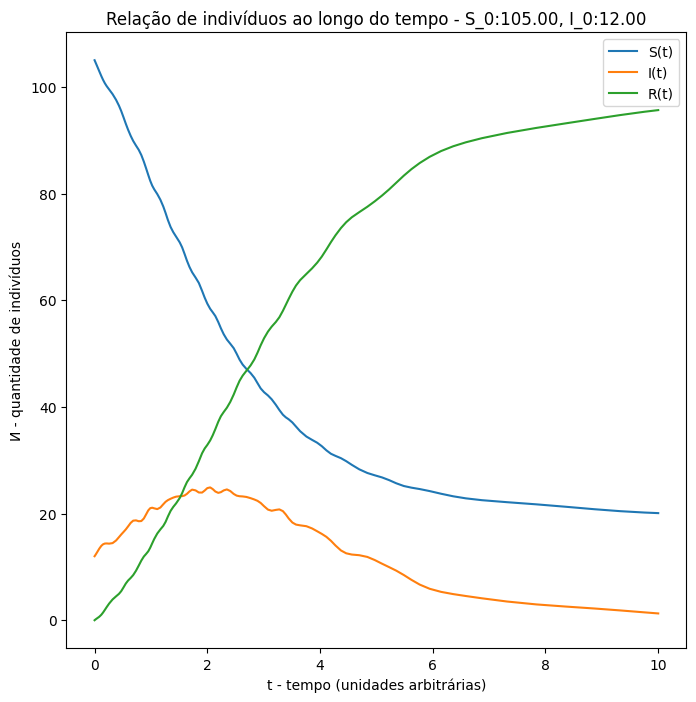

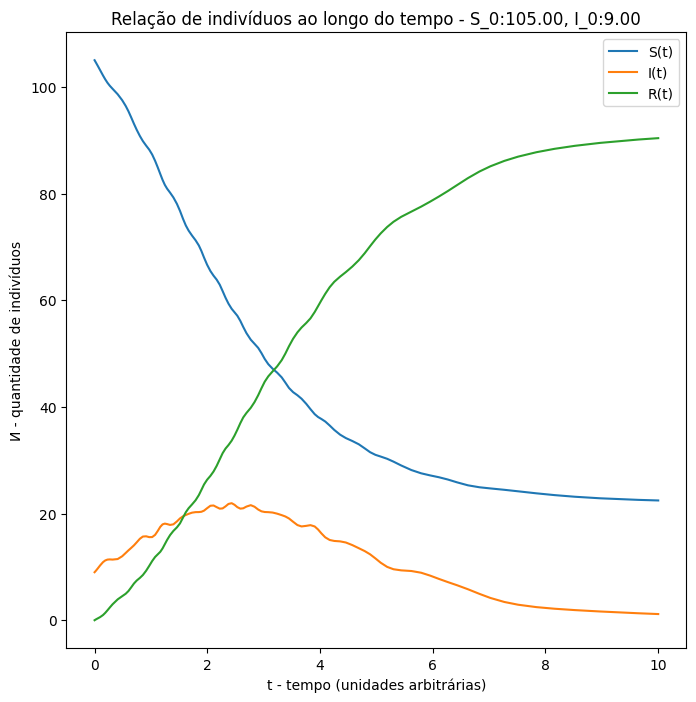

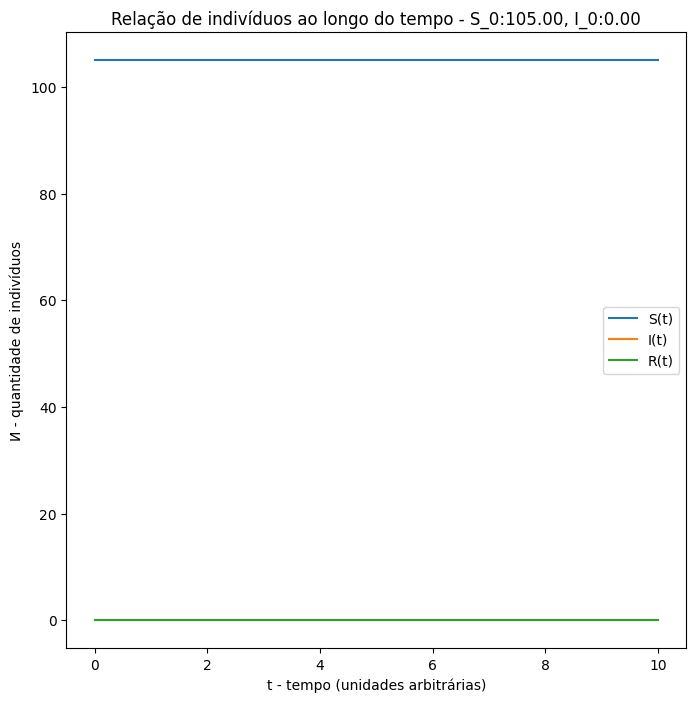

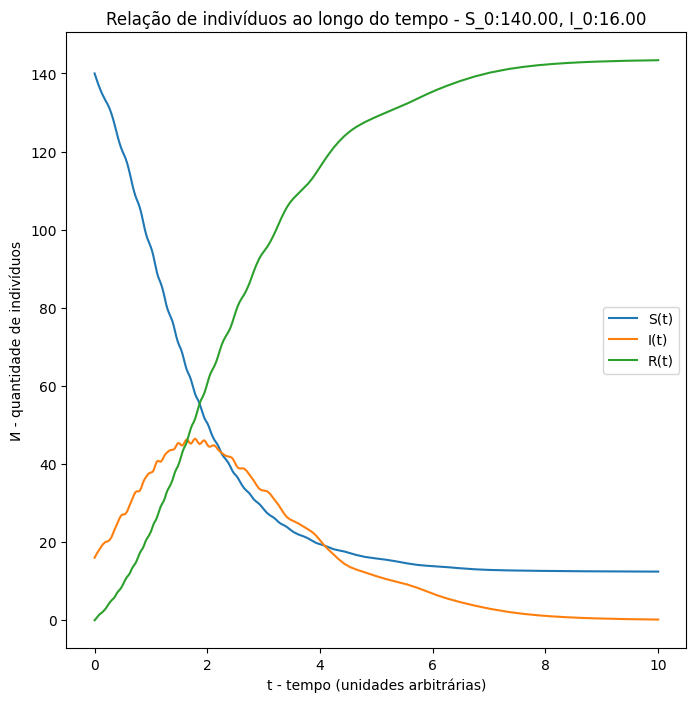

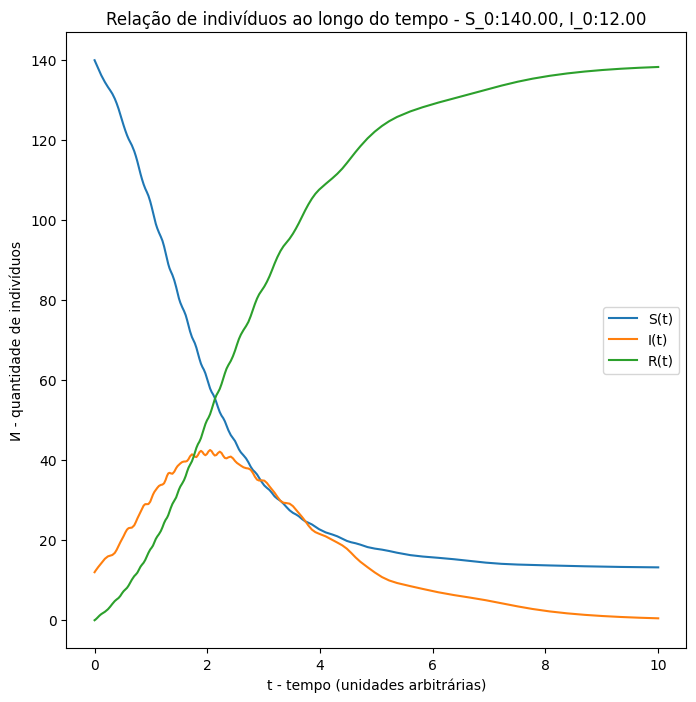

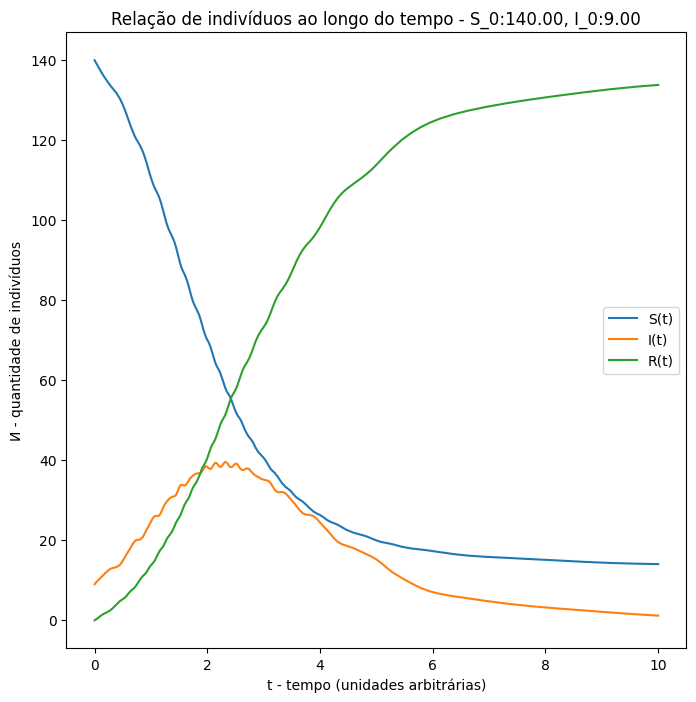

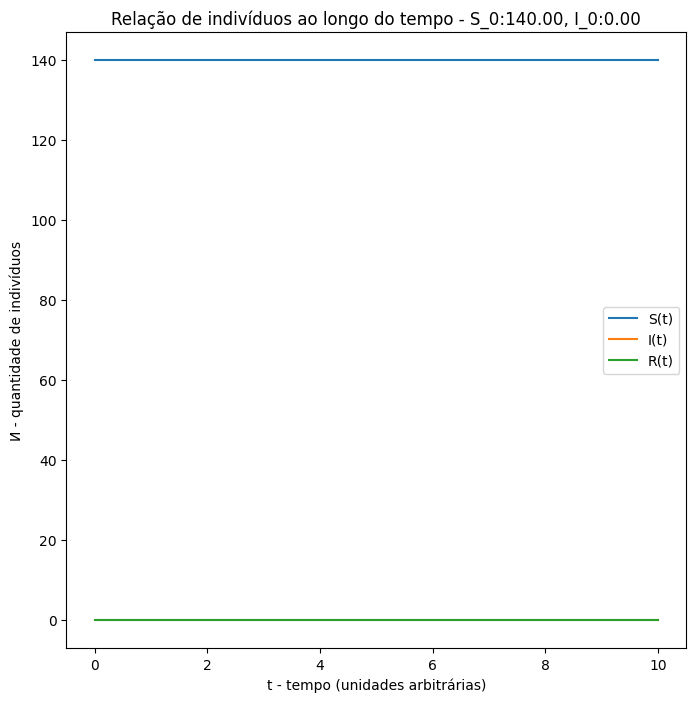

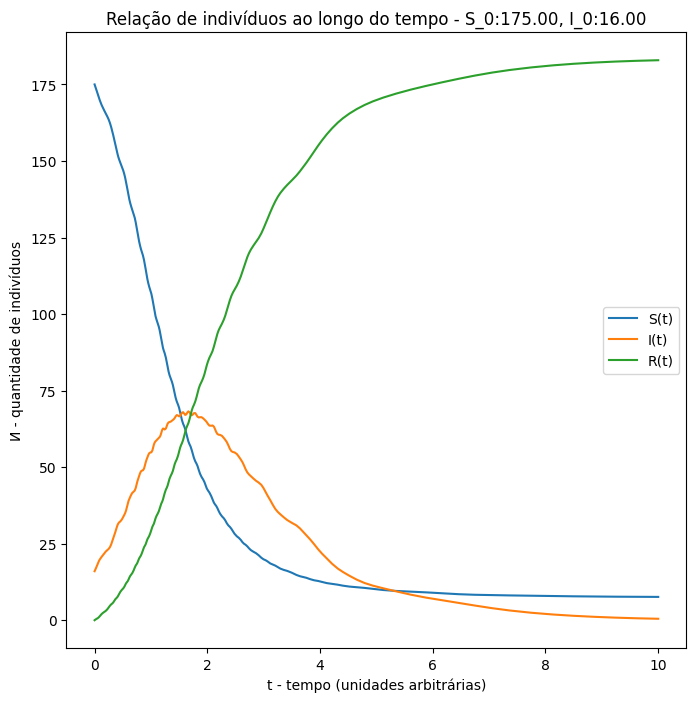

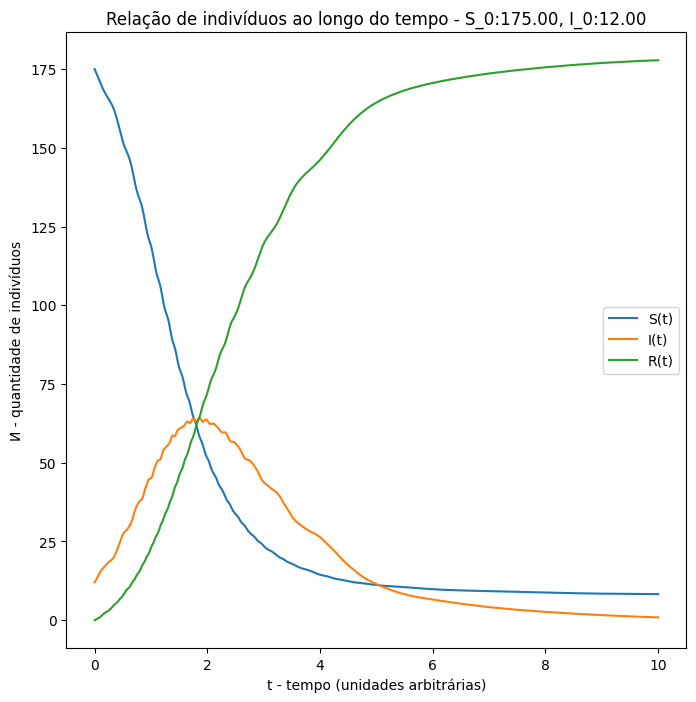

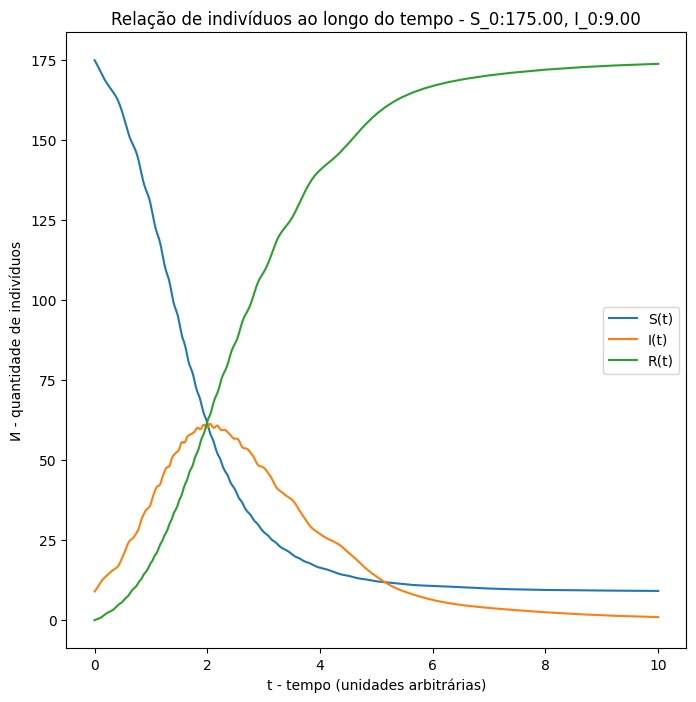

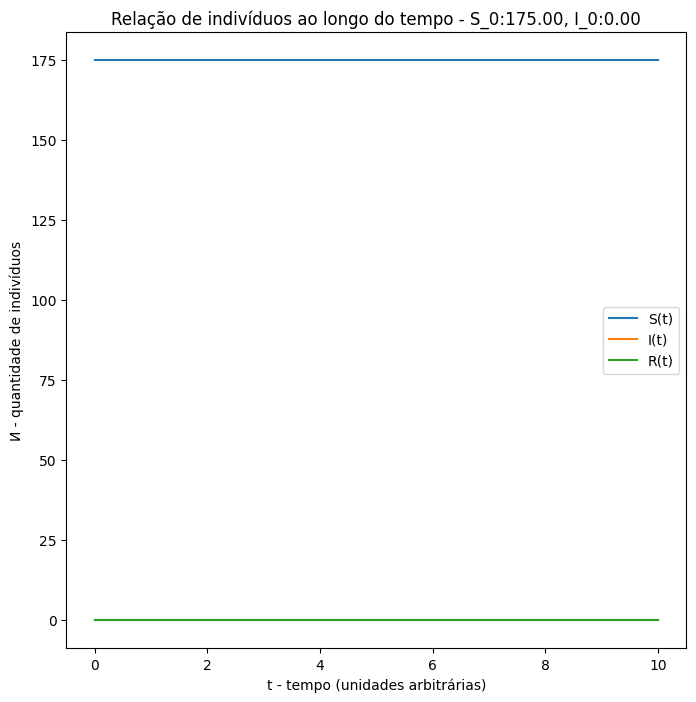

In [94]:
for S_0 in S_0_array:
    for I_0 in I_0_array:
        plt.figure(figsize = (8, 8))
        plt.title(f'Relação de indivíduos ao longo do tempo - S_0:{S_0:.2f}, I_0:{I_0:.2f}')
        plt.xlabel('t - tempo (unidades arbitrárias)')
        plt.ylabel('И - quantidade de indivíduos')
        t, S, I, R = results[(S_0, I_0)]
        plt.plot(t, S, label = 'S(t)')
        plt.plot(t, I, label = 'I(t)')
        plt.plot(t, R, label = 'R(t)')
        plt.legend()
        plt.show()